In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, peak_widths
from scipy.stats import mode
from statsmodels.robust import mad
from numpy.random import normal

import pandas as pd

# Include the utils functions
import os
import sys
sys.path.insert(0, os.path.abspath('./'))
from utils import *

import warnings
warnings.filterwarnings('ignore')

boxcar_window_size = 3001
matched_filter_window_length = (3000./3600)
matched_filter_depth = 1./np.pi
matched_filter_fwhm = 1./3600
detection_threshold = 5.
matched_filter_num_fwhm = 15

dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated"

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

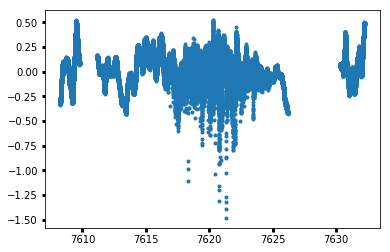

In [4]:
# 2020 Aug 5 - Cycle through all available sols and figure out which ones have the largest and smallest scatters
sols = range(14, 477)

new_filename = "filtered_pressure_scatter.csv"
f = open(new_filename, "w")
f.write("# sol, scatter\n")

stds = np.array([])
for cur_sol in sols:
# for cur_sol in [317]:
    try:
        LTST, LTST_and_sol, sol_data = retrieve_pressure_data(cur_sol, dr=dr)

        pressure_filter = savgol_filter(sol_data["PRESSURE"], boxcar_window_size, 0, mode='nearest')
#         plt.plot(LTST_and_sol, sol_data["PRESSURE"] - pressure_filter, marker='.', ls='')
    
#     plt.plot(LTST_and_sol[ind], np.ones_like(LTST_and_sol[ind])*np.nanmedian(sol_data["PRESSURE"]), marker='o')
#         plt.plot(LTST_and_sol, pressure_filter, marker='.', ls='')

        cur_std = np.nanstd(sol_data['PRESSURE'] - pressure_filter)
        write_str = "%i, %g" % (cur_sol, cur_std)
        print(write_str)
        f.write(write_str + "\n")

        stds = np.append(stds, cur_std)

    except:
        print(cur_sol)
        pass

# f.close()

# data = np.genfromtxt(new_filename, delimiter=',', comments='#', names=True)

# fig = plt.figure(figsize=(6*aspect_ratio, 6))
# ax = fig.add_subplot(111)
# ax.scatter(data['sol'], data['scatter'], color=BoiseState_blue, s=100)

# ax.grid(True)
# ax.set_title(r'$W = $%i' % boxcar_window_size, fontsize=36)
# ax.set_xlabel("sol", fontsize=36)
# ax.set_ylabel(r'$\sigma_P$', fontsize=36)
# ax.tick_params(labelsize=24)

# print(np.min(data['scatter']), np.median(data['scatter']), np.max(data['scatter']))
# print(data['sol'][np.argmax(data['scatter'])])
# print(data['sol'][np.argmin(np.abs(data['scatter'] - np.median(data['scatter'])))])
# print(data['sol'][np.argmin(data['scatter'])])
# print(data['scatter'][data['sol'] == 65])

# max_sol = int(data['sol'][np.argmax(data['scatter'])])
# med_sol = int(data['sol'][np.argmin(np.abs(data['scatter'] - np.median(data['scatter'])))])
# min_sol = int(data['sol'][np.argmin(data['scatter'])])

# fig.savefig(new_filename.replace("csv", "png"), dpi=500, bbox_inches='tight')

In [1]:
fig = plt.figure(figsize=(10*aspect_ratio, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# plt.setp(ax2.get_yticklabels(), visible=False)

# This calculation reflects the change in Delta P from the Savitsky-Golay filter

x = np.linspace(1, 1000, 1000)
f = 1. - np.arctan(x)/x
ax1.semilogx(x, f, color=BoiseState_blue, lw=3)
print(f[np.argmin(np.abs(x - 100.))])

ax1.set_xlabel(r'$W/\Gamma_{\rm obs}$', fontsize=36)
ax1.set_ylabel(r'$\Delta P_{\rm obs}^\prime/\Delta P_{\rm obs}$', fontsize=36)
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.text(0.05, 0.85, "(a)", fontsize=48, transform=ax1.transAxes)

### (b) ###

# sol = min_sol
# LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol, dr=dr)
# LTST_and_sol -= 24.*sol

# delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
# min_window_size = np.log10(10./3600)
# max_window_size = np.log10(5000./3600)
# window_lengths_int = np.ceil((10**(np.arange(min_window_size, max_window_size + 0.1, 0.1))/delta_t)) // 2 * 2 + 1 
# window_lengths = window_lengths_int*delta_t*3600.

# stds = np.array([])
# for i in range(len(window_lengths)):
#     pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
#     stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
# ax2.loglog(window_lengths, stds, color=BoiseState_blue, lw=3, label="sol %i" % min_sol)

# sol = med_sol
# LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol, dr=dr)
# LTST_and_sol -= 24.*sol
# stds = np.array([])
# for i in range(len(window_lengths)):
#     pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
#     stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
# ax2.loglog(window_lengths, stds, color=BoiseState_orange, lw=3, ls='--', label="sol %i" % med_sol)

# sol = max_sol
# LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol, dr=dr)
# LTST_and_sol -= 24.*sol
# stds = np.array([])
# for i in range(len(window_lengths)):
#     pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
#     stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
# ax2.loglog(window_lengths, stds, color='green', lw=3, ls='-.', label="sol %i" % max_sol)

# ax2.legend(loc="lower right", fontsize=18)

# ax2.set_xlabel(r'$W\,\left( {\rm s} \right)$', fontsize=36)
# ax2.set_ylabel(r'$\sigma_P$', fontsize=36)
# ax2.grid(True)
# ax2.tick_params(labelsize=24)
# ax2.yaxis.set_label_position("right")
# ax2.yaxis.tick_right()
# ax2.text(0.05, 0.85, "(b)", fontsize=48, transform=ax2.transAxes)
 
# fig.savefig("../figures/Pobsprime-sigmaP_vs_W.png", dpi=500, bbox_inches="tight")

NameError: name 'plt' is not defined

In [2]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
sol = 323
LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

# Generate synthetic data
baseline = 0.
slope = -10.
t0 = np.median(LTST_and_sol)
sol_data['PRESSURE'] = modified_lorentzian(LTST_and_sol, 
                                           baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
    normal(scale=matched_filter_depth/5., size=LTST_and_sol.shape)

fig = plt.figure(figsize=(10*aspect_ratio, 10))

### Raw Data ###

ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
        (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

ax1 = fig.add_subplot(221)
ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
ax1.text(0.05, 0.8, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24, labelbottom=False)
ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

### Filtered Data ###

ax2 = fig.add_subplot(223)

filtered_pressure, st = boxcar_filter(sol_data['PRESSURE'], boxcar_window_size)

ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
ax2.text(0.05, 0.8, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST (hours)", fontsize=36)
ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
ax2.set_ylim([-1, 1])

### Matched Filter ###

# Convolve with Lorentzian

convolution, med, md = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                                      matched_filter_fwhm, matched_filter_depth, boxcar_window_size)

ax3 = fig.add_subplot(222)
ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
ax3.axhline(med + detection_threshold*md, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

ax3.set_ylabel(r'$\left( F \ast \frac{\Delta P}{\sigma_P} \right)$', fontsize=36)
# ax3.set_xlabel("LTST (hours)", fontsize=36)
ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

### Fit Vortex ###
ax4 = fig.add_subplot(224)

ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)
for cur_ex in ex:
    ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    
# Take largest one
# mx_ind = np.argmax(convolution[ex])
mx_ind = np.argmin(convolution[ex])
# mx_ind = np.argmin(np.abs(convolution[ex] - np.median(convolution[ex])))
# mx_ind = 7
mx_width = int(pk_wds[mx_ind])

# Use original, unfiltered data
vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                   sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                        ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

init_params = determine_init_params(vortex)
bounds = determine_bounds(vortex, init_params)

popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)

ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], yerr=errs, ls='', marker='o', color=BoiseState_blue)
ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
         lw=3, color=BoiseState_orange, zorder=-1)

ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.2g$\\pm$%.1g) Pa \n $\\Gamma_{\\rm obs} = $(%.2g$\\pm$%.1g) s" %\
                       (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
         fontsize=20, transform=ax4.transAxes)
ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

print((np.max(convolution[ex]) - med)/md)

# fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')

NameError: name 'retrieve_pressure_data' is not defined

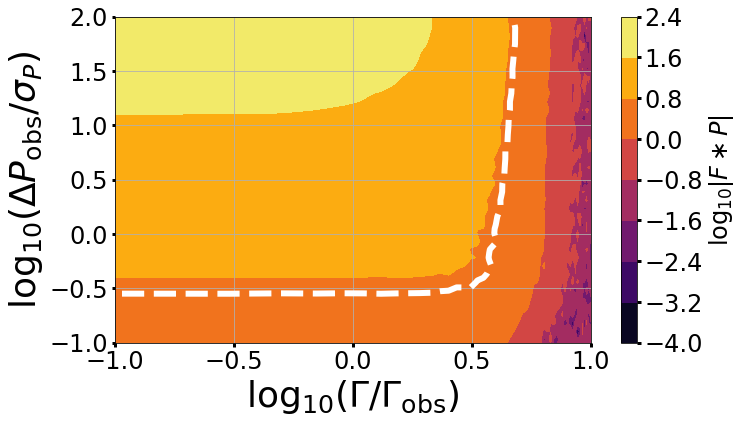

In [12]:
# sol = 65
sol = 323
# LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol, dr=dr)
# LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

# Generate synthetic data
baseline = 0.
slope = 0.
t0 = np.median(LTST_and_sol)

time = np.arange(-20.*matched_filter_fwhm, 20.*matched_filter_fwhm, delta_t) + t0

num_factors = 50
num_simulations = 200
noise_factors = 10**(np.linspace(2.2, -1.5, num_factors))
width_factors = np.linspace(0.1, 10., num_factors)

# recovery = np.zeros([num_simulations, num_factors, num_factors])
# for i in range(num_simulations):
#     for j in range(num_factors):
#         for k in range(num_factors):
#             data = modified_lorentzian(time, baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
#             normal(scale=matched_filter_depth/noise_factors[k], size=time.shape)
            
#             convolution =\
#                 apply_lorentzian_matched_filter(time, data, matched_filter_depth/noise_factors[k], 
#                                                 matched_filter_fwhm*width_factors[j], matched_filter_depth)
#             # What convolution do you get for the peak?
#             ind = np.argmin(np.abs(time - t0))
            
#             med = np.median(convolution)
#             md = mad(convolution)
#             recovery[i,j,k] = (convolution[ind] - med)/md
            
X, Y = np.meshgrid(np.log10(width_factors), np.log10(noise_factors))
fig = plt.figure(figsize=(6*aspect_ratio, 6))
# ax = fig.add_subplot(111)

# cp = ax.contourf(X, Y, np.log10(np.mean(recovery, axis=0)))
# fig.colorbar(cp) # Add a colorbar to a plot

CS = plt.contour(X, Y, np.log10(np.abs(np.mean(recovery, axis=0))), 
                 levels = [np.log10(5)], linewidths=(6,), colors=('white'), linestyles=("--"))
# CS = plt.contourf(X, Y, np.log10(np.mean(recovery, axis=0)), 
#                   np.array([np.log10(1), np.log10(3), np.log10(5), 
#                             np.log10(10), np.log10(30), np.log10(50), 
#                             np.log10(100), np.log10(300)]), cmap='inferno')
CS = plt.contourf(X, Y, np.log10(np.abs(np.mean(recovery, axis=0))), cmap='inferno')

CB = plt.colorbar(CS, extend='both')
CB.ax.tick_params(labelsize=24) 
CB.set_label(r'$\log_{10} | F\ast P |$', fontsize=24)
plt.ylim([-1, 2])

plt.tick_params(labelsize=24)
plt.xlabel(r'$\log_{10} \left( \Gamma/\Gamma_{\rm obs} \right)$', fontsize=36)
plt.ylabel(r'$\log_{10} \left( \Delta P_{\rm obs}/\sigma_P \right)$', fontsize=36)

plt.grid(True)

# plt.semilogx(1/noise_factors, np.mean(recovery[:,:,0], axis=0))
# plt.semilogx(matched_filter_depth/noise_factors, np.mean(recovery[:,:,1], axis=0))
# plt.semilogx(matched_filter_depth/noise_factors, np.mean(recovery[:,:,2], axis=0))

# sol_data['PRESSURE'] = modified_lorentzian(LTST_and_sol, 
#                                            baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
#     normal(scale=matched_filter_depth/5., size=LTST_and_sol.shape)

fig.savefig("../figures/vortex_recovery.png", dpi=500, bbox_inches="tight")

12.131883362569477


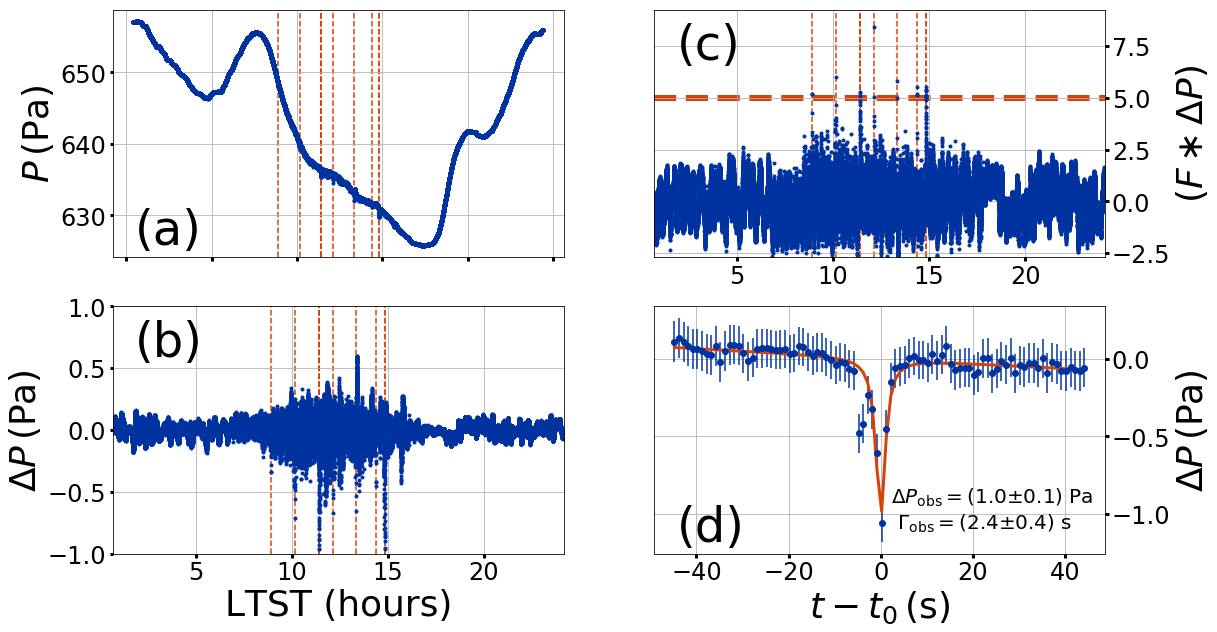

In [10]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
# sol = 323
sol = med_sol

LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

fig = plt.figure(figsize=(10*aspect_ratio, 10))

### Raw Data ###

ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
        (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

ax1 = fig.add_subplot(221)
ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
ax1.text(0.05, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24, labelbottom=False)
ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

### Filtered Data ###

ax2 = fig.add_subplot(223)

filtered_pressure, st = boxcar_filter(sol_data['PRESSURE'], boxcar_window_size)

ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
ax2.text(0.05, 0.8, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST (hours)", fontsize=36)
ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
ax2.set_ylim([-1, 1])

### Matched Filter ###

# Convolve with Lorentzian

convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                                      matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
med = np.median(convolution)
md = mad(convolution)

convolution -= med
convolution /= md

ax3 = fig.add_subplot(222)
ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
ax3.axhline(detection_threshold, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

ax3.set_ylabel(r'$\left( F \ast \Delta P \right)$', fontsize=36)
# ax3.set_xlabel("LTST (hours)", fontsize=36)
ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax3.set_xlim([8., 10.])
ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

### Fit Vortex ###
ax4 = fig.add_subplot(224)

ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)
for cur_ex in ex:
    ax1.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    
# Take largest one
mx_ind = np.argmax(convolution[ex])
# mx_ind = np.argmin(convolution[ex])
# mx_ind = np.argmin(np.abs(convolution[ex] - np.median(convolution[ex])))
# mx_ind = 7
mx_width = np.max([2, int(pk_wds[mx_ind])])

# Use original, unfiltered data
vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                   sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                        ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

init_params = determine_init_params(vortex)
bounds = determine_bounds(vortex, init_params)

popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)
print(popt[2])

ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
             yerr=errs, ls='', marker='o', color=BoiseState_blue)
ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
         lw=3, color=BoiseState_orange)

# ax4.text(0.05, 0.05, "(d), %g" % matched_filter_num_fwhm, fontsize=48, transform=ax4.transAxes)
ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.1f$\\pm$%.1f) Pa \n $\\Gamma_{\\rm obs} = $(%.1f$\\pm$%.1f) s" %\
                       (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
         fontsize=20, transform=ax4.transAxes)
ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')

['/Users/bjackson/Downloads/ps_bundle/data_calibrated/sol_0390_0477/ps_calib_0435_01.csv']


ValueError: zero-size array to reduction operation minimum which has no identity

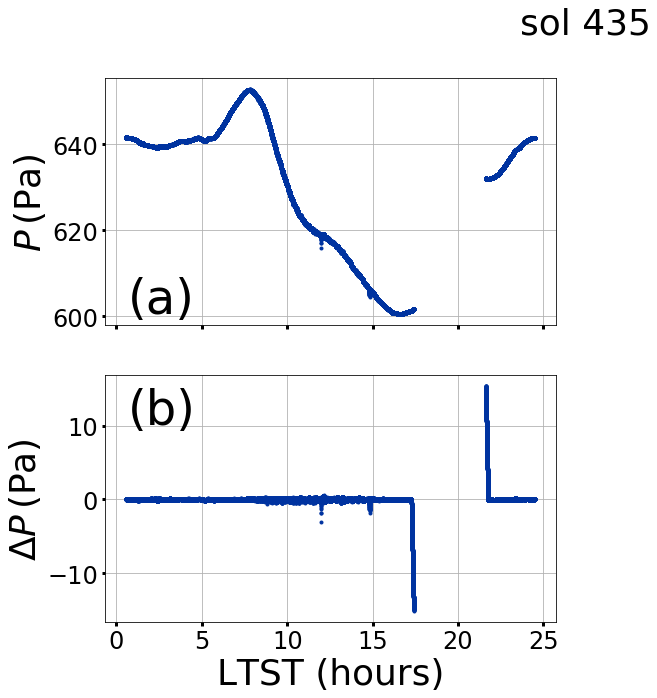

In [26]:
# 2020 Aug 8 - Next find all the vortices
sols = range(14, 477)

new_filename = "all_vortices_2020Aug8.csv"
# f = open(new_filename, "w")
# f.write("# sol, scatter\n")

# for cur_sol in sols[2:3]:
for cur_sol in [max_sol]:
    
    sol_filename = create_datafilename(cur_sol, dr=dr)
    print(sol_filename)
    if(len(sol_filename) > 0):
        fig = plt.figure(figsize=(10*aspect_ratio, 10))
        plt.suptitle("sol " + str(cur_sol), fontsize=36)
        
        ### Read in data and make plot ###
        
        LTST, LTST_and_sol, sol_data = retrieve_pressure_data(cur_sol, dr=dr)
        LTST_and_sol -= 24.*cur_sol
        delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

        ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
                (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

        ax1 = fig.add_subplot(221)
        ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
        ax1.text(0.05, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
        ax1.grid(True)
        ax1.tick_params(labelsize=24, labelbottom=False)
        ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

        ### Filtered Data ###

        ax2 = fig.add_subplot(223)

        filtered_pressure, st = boxcar_filter(sol_data['PRESSURE'], boxcar_window_size)

        ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
        ax2.text(0.05, 0.8, "(b)", fontsize=48, transform=ax2.transAxes)
        ax2.grid(True)
        ax2.tick_params(labelsize=24)
        ax2.set_xlabel("LTST (hours)", fontsize=36)
        ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

        ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
        ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])

### Matched Filter ###

        # Convolve with Lorentzian

        convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                                              matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
        med = np.median(convolution)
        md = mad(convolution)

        convolution -= med
        convolution /= md

        ax3 = fig.add_subplot(222)
        ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
        ax3.axhline(detection_threshold, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
        ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
        ax3.grid(True)
        ax3.yaxis.set_label_position("right")
        ax3.yaxis.tick_right()
        ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

        ax3.set_ylabel(r'$\left( F \ast \Delta P \right)$', fontsize=36)
        ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
        ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

        ### Fit Vortex ###
        ax4 = fig.add_subplot(224)

        ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)

        if(len(ex) > 0):
        
            for cur_ex in ex:
                ax1.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
                ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
                ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')

            # Take largest one
            mx_ind = np.argmax(convolution[ex])
            mx_width = np.max([2, int(pk_wds[mx_ind])])

            # Use original, unfiltered data
            vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                            ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                               sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                                    ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

            errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

            init_params = determine_init_params(vortex)
            bounds = determine_bounds(vortex, init_params)

            popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)

            ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
                         yerr=errs, ls='', marker='o', color=BoiseState_blue)
            ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
                     lw=3, color=BoiseState_orange)

            # ax4.text(0.05, 0.05, "(d), %g" % matched_filter_num_fwhm, fontsize=48, transform=ax4.transAxes)
            ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
            ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.1f$\\pm$%.1f) Pa \n $\\Gamma_{\\rm obs} = $(%.1f$\\pm$%.1f) s" %\
                                   (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
                     fontsize=20, transform=ax4.transAxes)
            ax4.grid(True)
            ax4.yaxis.set_label_position("right")
            ax4.yaxis.tick_right()
            ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
            ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
            ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

# # fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')